#### <span style="color:#a50e3e;">Exercise 4: </span>  Use Deep Q Learning to solve an OpenAI Gym problem

In this exercise you will use a simulator provided by the popular [OpenAI Gym](https://gym.openai.com/) and perform Deep Q-Learning to learn an optimal control law for a particular problem (called an      Environment) there.  You can learn how to install and get started using the gym by examining the [appropriate documentation](https://gym.openai.com/docs/). 

The syntax for initializing and updating any simulator in the gym mirrors that used for gridworld in the previous problem.  That is to initialize any of the simulators you use the following command

```
state = simulator.reset()
```

and to take a step (based on a permittable action) you likewise use the command

```
next_state, reward, done, info = simulator.step(action)
```

Solve the problems listed at the end of the [course notes](https://www.dropbox.com/s/xsmkjgswelu2f4v/Q_to_deepQ_notes_SLIDES.pdf?dl=0) using Deep Q Learning, that is


- the [cartpole problem](https://gym.openai.com/envs/CartPole-v1/) 


- the [lunar lander problem](https://gym.openai.com/envs/LunarLander-v2/)


Here 'solved' means being able to accomplished the stated goal for each task as listed on their introductory pages above.  

Note a few technical points about your final implementation:

- **Defining your network:** For this exercise you can use Python, PyTorch, or Keras / Tensorflow to define / update your network architectures.  A pure-Python network builder - the one used to perform multi-output regression in the [course notes](https://www.dropbox.com/s/xsmkjgswelu2f4v/Q_to_deepQ_notes_SLIDES.pdf?dl=0) is shown in the included file `pure_python_multi_output_func_scratch.ipynb` in the `pure_python_architecture_examples` subdirectory.  You can see an example of how to build a network architecture using PyTorch or Tensorflow - using the cartpole problem as a test simulator - in tutorials like [this one for PyTorch](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) or [this one for Tensorflow](https://keon.io/deep-q-learning/) (note in the former case a convnet is being used, you need only use a multilayer perceptron for these exercises).  *Note:* do not simply copy and paste one of these tutorials for your submission!  If you use a tutorial like one of these as a base for your own development work thats fine, but make sure to actually understand, digest, and re-organize it as detailed in class.


- **Network structure:** You shouldn't need too deep a network for either of these problems.  In our experiments a two or three layer fully connected network with less than 100 units per layer worked fine (along with pretty much any activation).


- **Reward structure:** Examine the reward structure of these problems carefully, and make any ad-hoc changes to them.  For example, if the difference in reward between 'good' and 'bad' states is small numerically speaking, you can feel free to re-define these rewards in your Q-Learning loop


- **Other parameters:** Typically speaking you need not worry much about the short-term / long-term parameter, and it can be set to $\gamma = 1$ (or something close like $\gamma = 0.99$) for your entire training run.  The exploitation / exploration parameter can be set small - to a value like $0.1$ or even $0.01$ - for all iterations, or you can decrease it from $1$ to a small number like $0.1$ as your training progresses.  For the sake of simplicity, in both of the examples shown in the course notes we just kept this parameter fixed to $0.1$ for the entire training run.  Each of our runs took less than 1000 episodes of training for $Q$ to resolve well.

In [72]:
import sys
sys.path.append('../')
import autograd.numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

from keras.layers import Dense
from keras.optimizers import RMSprop, Adam
from keras.models import Sequential

class Agent:
    def __init__(self,state_size,action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.action_samples = []
        self.state_samples = []
        self.next_state_samples = []
        self.reward_samples = []
        self.done_samples = []
        self.Q = self.build_model(state_size,action_size)
        self.p = 1
        self.gamma = 1
        self.memory_size = 1000
        self.p_min = 0.01
        self.p_decay_rate = 0.995
        
    def create_io_pairs(self,batch_size):
        #  take  a  sample  of  tuples  from  replay  memory
        #self.sample_memory()
        #  generate  values  to  regress  on  based  on  most  recent  Q
        q_vals=[]
        idx_sample = np.random.choice(len(self.action_samples),batch_size,replace=False)
        #print(idx_sample)
        state_fit = []
        for i in idx_sample:
            #  grab  tuple  of  data
            state=self.state_samples[i]
            state_fit.append(state)
            next_state=self.next_state_samples[i]
            reward=self.reward_samples[i]
            done=self.done_samples[i]
            action=self.action_samples[i]
            #  compute  and  store  q  outputs  for  regression
            q=reward
            if done==False:
                qs=self.Q.predict(next_state)[0]
                q+=self.gamma*np.max(qs)
            #  clamp  all  other  models  to  their  current  values  
            #  for  this  input/output  pair
            #  by  creating  phantom  outputs
            q_update=self.Q.predict(state)[0]
            q_update[action]=q
            q_vals.append(q_update)
            q_update = np.reshape(q_update, [1, self.action_size])
        self.Q.fit(np.reshape(np.array(state_fit),[batch_size,self.state_size]),np.reshape(np.array(q_vals),[batch_size,self.action_size]),batch_size=batch_size,epochs=1,verbose=0) 
        return(q_vals)
    
    def sample_memory(self):
        
        return
    def update(self,batch_size):
        #  don't  regress  unless  sufficient  tuples  have  been  created
        if len(self.action_samples)<batch_size:
            return
        q_vals=self.create_io_pairs(batch_size)
        if self.p>self.p_min:
            self.p=self.p*self.p_decay_rate
        return
    
    #  choose  next  action
    def choose_action(self,state):
        r=np.random.rand(1)
        if r>self.p:
            #  choose action based on Q (exploit)
            action=np.argmax(self.Q.predict(state)[0])
        else:
            #  choose random action (explore)
            action=np.random.randint(self.action_size)
        return action
    
    def remember(self,state,next_state,action,reward,done):
        if len(self.action_samples)>=self.memory_size:
            self.state_samples.pop(0)
            self.next_state_samples.pop(0)
            self.action_samples.pop(0)
            self.reward_samples.pop(0)
            self.done_samples.pop(0)
        self.state_samples.append(state)
        self.next_state_samples.append(next_state)
        self.action_samples.append(action)
        self.reward_samples.append(reward)
        self.done_samples.append(done)
        return
    
    def build_model(self,x_size,y_size,**kwargs):
        # default parameters for network
        layer_sizes = [10,10]      # two hidden layers, 100 units each, by default
        activation = 'relu'
        if 'layer_sizes' in kwargs:
            layer_sizes = kwargs['layer_sizes']
        if 'activation' in kwargs:
            activation = kwargs['activation']

        # default parameters for optimizer - reset by hand
        loss = 'mse'
        optimizer = Adam(lr = 10**(-2))        

        # input / output sizes of network
        input_dim = x_size
        output_dim = y_size

        # build model based on parameters
        model = Sequential()

        # add input layer
        model.add(Dense(layer_sizes[0], input_dim=input_dim, activation=activation))

        # add hidden layers
        for U in layer_sizes[1:]:
            model.add(Dense(U,activation=activation))

        # add output layer
        model.add(Dense(output_dim, activation='softmax'))

        # chose optimizer and its associated parameters
        #model.summary()   # print out summary of network structure
        model.compile(loss=loss, optimizer=optimizer)
        return model
    
import matplotlib.pyplot as plt
from matplotlib import gridspec

#### compare cost function histories ####
def plot_cost_history(cost_history,start):        
    # initialize figure
    fig = plt.figure(figsize = (10,3))

    # create subplot with 1 panel
    gs = gridspec.GridSpec(1, 1) 
    ax = plt.subplot(gs[0]); 

    # plot train cost function history
    ax.plot(np.arange(start,len(cost_history),1),cost_history[start:],linewidth = 3*(0.8)**(1),label = 'reward') 

    # clean up panel / axes labels
    xlabel = 'step $k$'
    ylabel = 'reward'
    ax.set_xlabel(xlabel,fontsize = 14)
    ax.set_ylabel(ylabel,fontsize = 14,rotation = 0,labelpad = 25)

    # plot legend
    anchor = (1,1)
    plt.legend(loc='upper right', bbox_to_anchor=anchor)
    ax.set_xlim([start - 0.5,len(cost_history) - 0.5]) 
    plt.show()


def plot_reward_history(data,**kwargs):
    # load in total episode reward history
    #data = np.loadtxt(logname)
    ave = [data[v] for v in range(100)]
    
    for i in range(0,np.size(data)-100):
        m = np.mean(data[i:i+100])
        ave.append(m)
    
    # create figure
    fig = plt.figure(figsize = (12,8))
    ax1 = fig.add_subplot(2,1,1)
    ax2 = fig.add_subplot(2,1,2)

    # plot total reward history
    start = 0
    if 'start' in kwargs:
        start = kwargs['start']
    ax1.plot(data[start:])
    ax1.set_xlabel('episode',labelpad = 8,fontsize = 13)
    ax1.set_ylabel('total reward',fontsize = 13)
    
    ax2.plot(ave[start:],linewidth=3)
    ax2.set_xlabel('episode',labelpad = 8,fontsize = 13)
    ax2.set_ylabel('ave total reward',fontsize=13)
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
import gym
import copy
simulator = gym.make('CartPole-v1')
state_size = 4
action_size = 2
episodes = 500
batch_size = 32
#  start  episode  simulation
episode_rewards=np.zeros((episodes,1))
agent = Agent(state_size,action_size)
agent.p_decay_rate = 0.995
agent.p=0.1
agent.memory_size=1000
count_total = np.zeros((episodes,1))
for e in range(episodes):
    state = simulator.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    #counter = 0
    done=False
    while done==False:
        #  choose  next  action
        action=agent.choose_action(state)
        #  transition  to  next  state,  get  associated  reward
        next_state,reward,done,info=simulator.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        #  update  Q  function
        agent.remember(state,next_state,action,reward,done)
        agent.update(batch_size)
        #  update  total  reward  from  this  episode
        total_reward+=reward
        #counter  = counter + 1
        state=copy.deepcopy(next_state)
    
    episode_rewards[e]=total_reward
    print("Episode "+str(e)+", reward: "+str(episode_rewards[e]))

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Episode 0, reward: [78.]
Episode 1, reward: [52.]
Episode 2, reward: [54.]
Episode 3, reward: [58.]
Episode 4, reward: [56.]
Episode 5, reward: [54.]
Episode 6, reward: [54.]
Episode 7, reward: [115.]
Episode 8, reward: [131.]
Episode 9, reward: [96.]
Episode 10, reward: [89.]
Episode 11, reward: [114.]
Episode 12, reward: [64.]
Episode 13, reward: [57.]
Episode 14, reward: [133.]
Episode 15, reward: [71.]
Episode 16, reward: [174.]
Episode 17, reward: [54.]
Episode 18, reward: [72.]
Episode 19, reward: [238.]
Episode 20, reward: [179.]
Episode 21, reward: [68.]
Episode 22, reward: [61.]
Episode 23, reward: [91.]
Episode 24, reward: [106.]
Episode 25, reward: [56.]
Episode 26, reward: [48.]
Episode 27, reward: [142.]
Episode 28, reward: [156.]
Episode 29, reward: [108.]
Episode 30, reward: [82.]
Episode 31, reward: [44.]
Episode 32, reward: [69.]
Episode 33, reward: [203.]
Episode 34, rew

Episode 300, reward: [148.]
Episode 301, reward: [106.]
Episode 302, reward: [52.]
Episode 303, reward: [74.]
Episode 304, reward: [235.]
Episode 305, reward: [69.]
Episode 306, reward: [62.]
Episode 307, reward: [77.]
Episode 308, reward: [103.]
Episode 309, reward: [73.]
Episode 310, reward: [64.]
Episode 311, reward: [79.]
Episode 312, reward: [87.]
Episode 313, reward: [133.]
Episode 314, reward: [107.]
Episode 315, reward: [140.]
Episode 316, reward: [86.]
Episode 317, reward: [100.]
Episode 318, reward: [74.]
Episode 319, reward: [73.]
Episode 320, reward: [104.]
Episode 321, reward: [59.]
Episode 322, reward: [57.]
Episode 323, reward: [171.]
Episode 324, reward: [91.]
Episode 325, reward: [91.]
Episode 326, reward: [227.]
Episode 327, reward: [124.]
Episode 328, reward: [97.]
Episode 329, reward: [71.]
Episode 330, reward: [82.]
Episode 331, reward: [95.]
Episode 332, reward: [59.]
Episode 333, reward: [86.]
Episode 334, reward: [69.]
Episode 335, reward: [67.]
Episode 336, rew

<IPython.core.display.Javascript object>


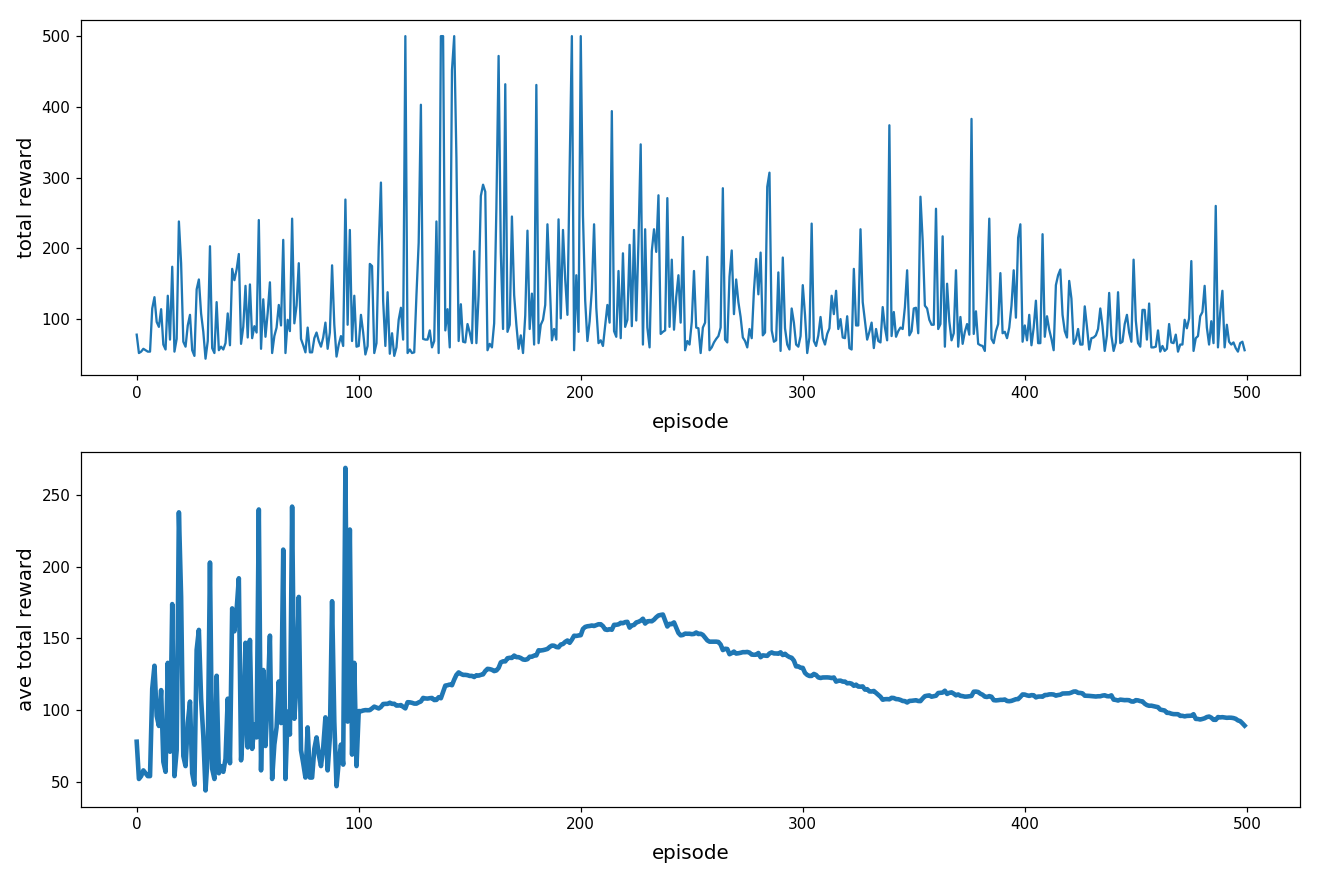

In [76]:
plot_reward_history(episode_rewards)

#### It seemed that this one depended fairly heavily on my initial configuration. Sometimes for the same parameters I would get wildy different results. This one seems to be about the average of what I was getting - at one point quite high. I used a pretty standard setup here, and set my exploration/exploitation parameter initially to 0.1, with a decay of 0.995 after each episode.